# Training / Play Metric Comparison

In [1]:
from functools import reduce
import glob
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## 0. Load TensorBoard files

In [2]:
scalar_tags = ['info/score',
 'info/duration',
 'info/policy_loss',
 'info/value_loss',
 'info/entropy_loss']

In [3]:
tb_paths = [p for p in glob.glob("experiments/*/runs/*") if 'tfevents' in p]

In [5]:
tmp = []

for tb_p in tb_paths:
    ea = event_accumulator.EventAccumulator(tb_p)
    ea.Reload()
    exp_name = tb_p.split("/")[1]
    
    row_tmp = []
    for scalar_t  in scalar_tags:
        df = pd.DataFrame(ea.Scalars(scalar_t))
        df['exp_name'] = exp_name
        df.rename(columns={'value': scalar_t}, inplace=True)
        row_tmp.append(df[['exp_name', 'step', scalar_t]])
        
    row_df = reduce(lambda x, y: pd.merge(x, y, on=['exp_name', 'step']), row_tmp)
    tmp.append(row_df)
    
master_df = pd.concat(tmp)

/Users/jastills/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jastills/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jastills/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jastills/anaconda3/envs/rl/lib/python3.6/s

In [6]:
master_df.head()

,exp_name,step,info/score,info/duration,info/policy_loss,info/value_loss,info/entropy_loss
0,PPO_M_gail_s3_bc_ep6,8,-188.143768,114.00,0.014710,6.275202,-0.636369
1,PPO_M_gail_s3_bc_ep6,23,-60.148663,105.00,0.016137,4.702908,-0.530829
2,PPO_M_gail_s3_bc_ep6,30,-60.148663,105.00,0.010855,3.932282,-0.577529
3,PPO_M_gail_s3_bc_ep6,43,-60.148663,105.00,0.012252,2.672829,-0.696216
4,PPO_M_gail_s3_bc_ep6,51,-37.015812,101.25,-0.000632,4.337482,-0.710746


# 1. Training Score
## 1-1. Maximum AVG. Training Score

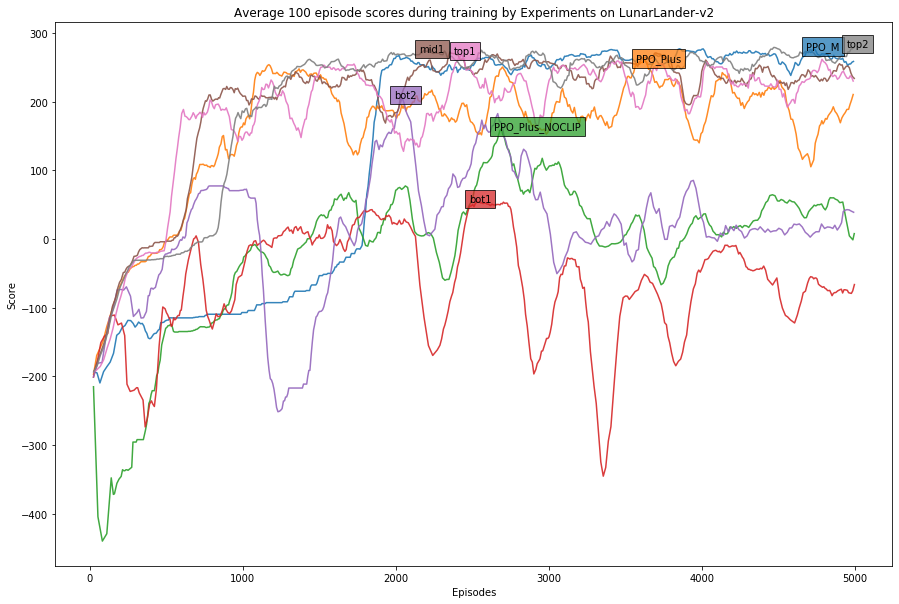

In [6]:
exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',
             'bot1','bot2',
             'mid1', # mid2 == PPO_PLUS
             'top1','top2']
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/score'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    # to prevent labels overlapping each other
    if label in ['mid1', 'mid2']:
        xp -= 200
    else:
        xp -= 50
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, label, bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average 100 episode scores during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")
plt.show()

## 1-2. Episode that beat the minimum score threshold

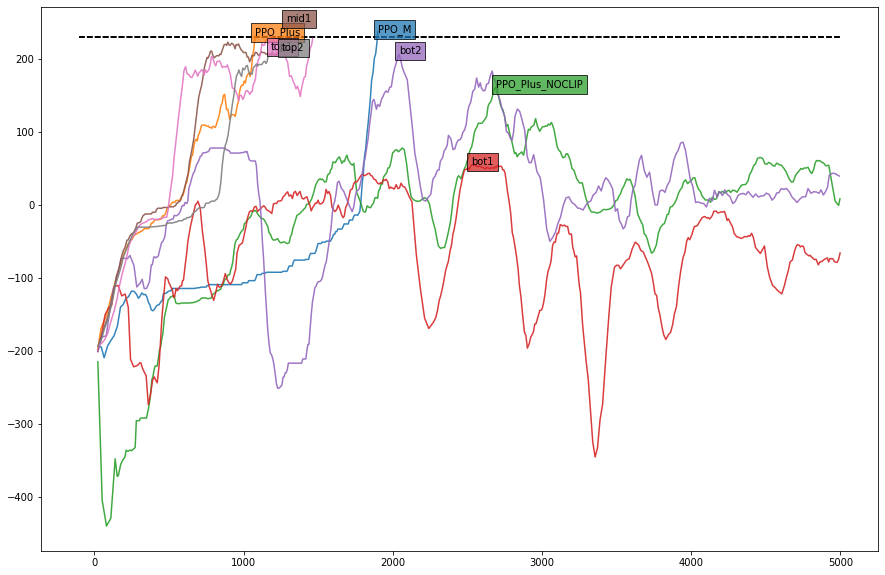

In [7]:
score_threshold = 230

thres_df = master_df.copy()
thres_df['over_threshold'] = thres_df['info/score'] >= score_threshold
thres_df['ot_tmp'] = thres_df.groupby('exp_name').over_threshold.cumsum()
thres_df2 = thres_df[lambda x: x.ot_tmp <= 1]

exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',
             'bot1','bot2',
             'mid1',
             'top1','top2']
f_df = thres_df2[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/score'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    # to prevent labels overlapping each other
    if label in ['mid1', 'mid2']:
        yp += 20
    elif label in ['top1', 'top2']:
        yp -= 20
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, label, bbox=dict(facecolor=line_color, alpha=0.75))
    
    ax.hlines(y=230, xmin=-100, xmax=5000, alpha=0.5, linestyle="--")

plt.show()

## 1-3. Comparing PPO_M, PPO_Plus, PPO_Plus_NOCLIP

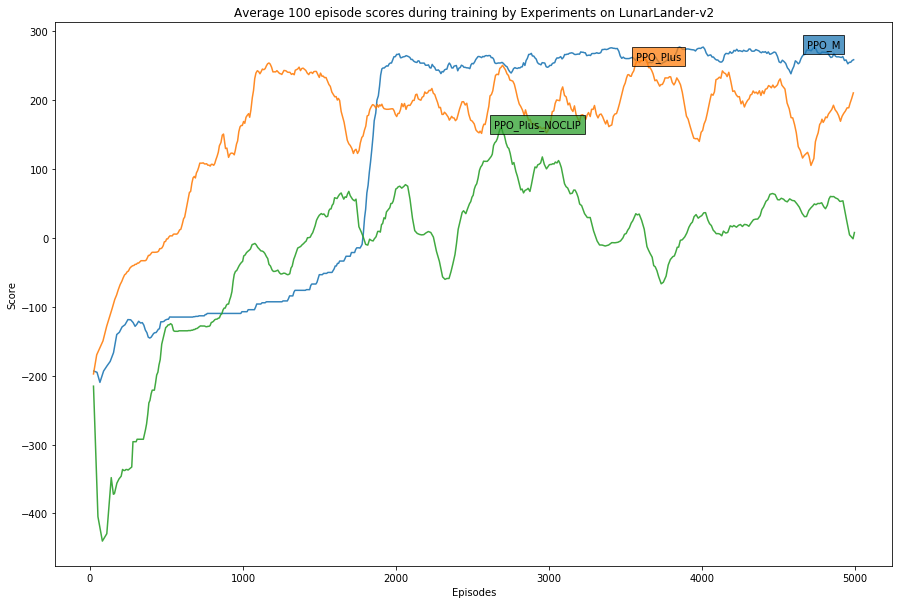

In [8]:
exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',]
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/score'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    # to prevent labels overlapping each other
    if label in ['mid1', 'mid2']:
        xp -= 200
    else:
        xp -= 50
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, label, bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average 100 episode scores during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")
plt.show()

## 1-4. Comparing top1, top2 from Bayesian Optimization and PPO_PLUS

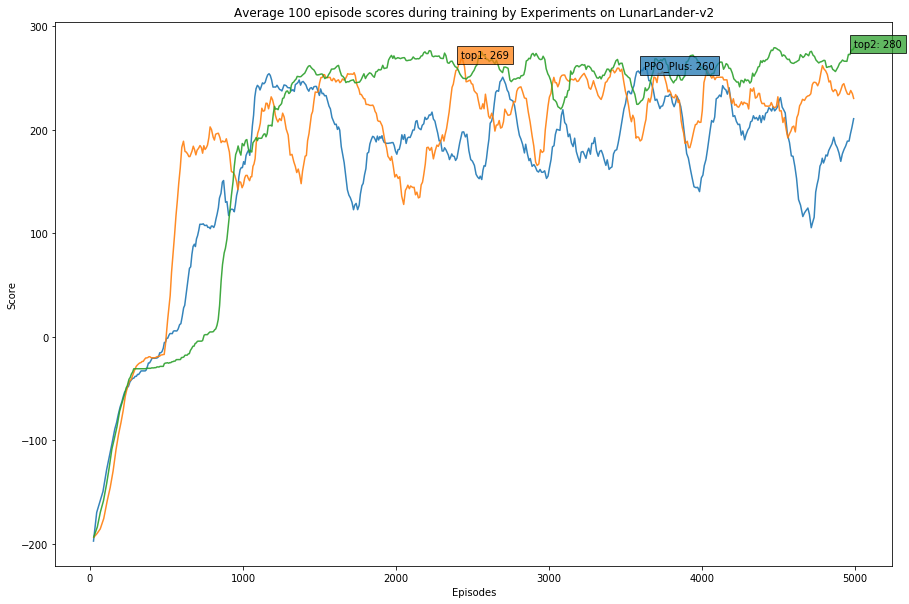

In [9]:
exp_names = ['top1', 'top2','PPO_Plus']
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/score'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, '{}: {:.0f}'.format(label, yp), bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average 100 episode scores during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")
plt.show()

# 2. Training Loss
## 2-1. Policy Loss

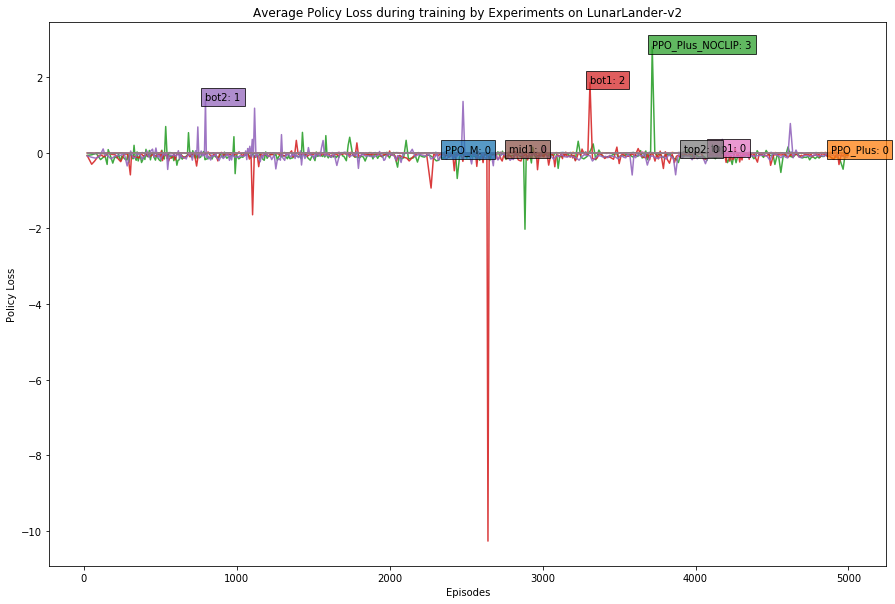

In [20]:
exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',
             'bot1','bot2',
             'mid1',
             'top1','top2']
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/policy_loss'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, '{}: {:.0f}'.format(label, yp), bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average Policy Loss during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Policy Loss")
plt.show()

## 2. Value Loss

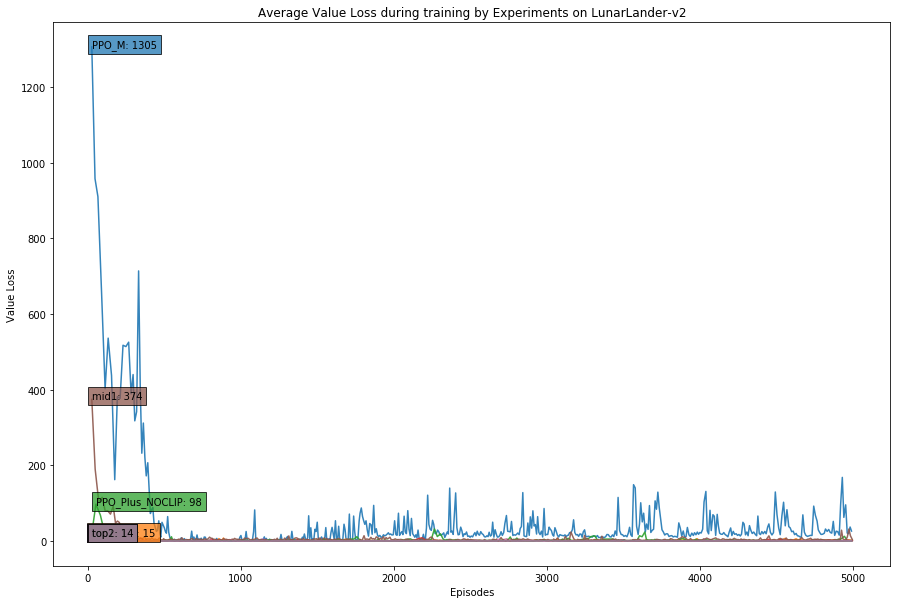

In [11]:
exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',
             'bot1','bot2',
             'mid1',
             'top1','top2']
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/value_loss'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, '{}: {:.0f}'.format(label, yp), bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average Value Loss during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Value Loss")
plt.show()

## 3. Entropy Loss

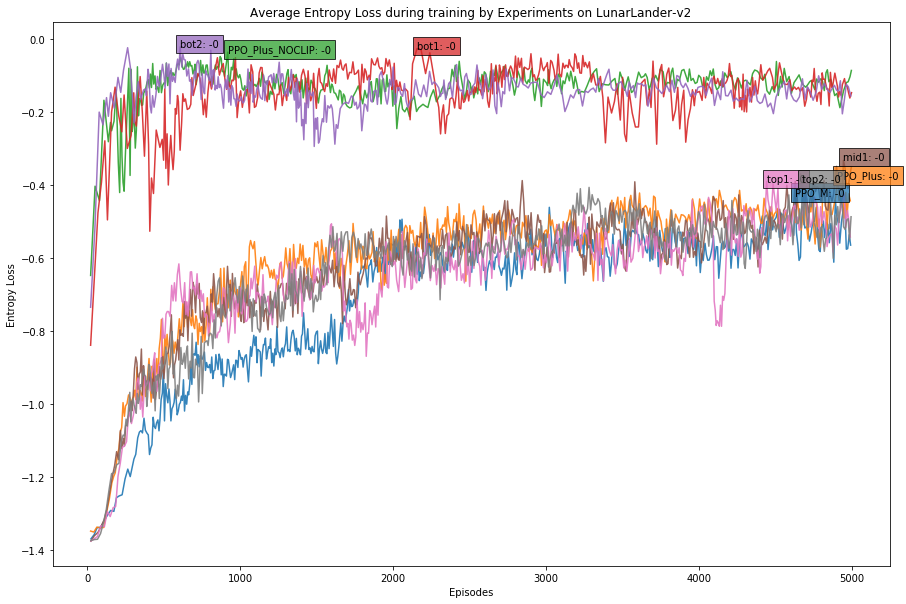

In [12]:
exp_names = ['PPO_M', 'PPO_Plus', 'PPO_Plus_NOCLIP',
             'bot1','bot2',
             'mid1',
             'top1','top2']
f_df = master_df[lambda x: x.exp_name.isin(exp_names)]

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
g = f_df.groupby('exp_name')
for label, exp_df in g:
    exp_df = exp_df.sort_values(by='step')
    ax_p = ax.plot(exp_df.step, exp_df['info/entropy_loss'], label=label, alpha=0.9)
    
    yidx, yp = np.argmax(ax_p[0].get_ydata()), np.max(ax_p[0].get_ydata())
    
    xp = ax_p[0].get_xdata()[yidx]
    
    line_color = ax_p[0].get_color()

    ax.text(xp, yp, '{}: {:.0f}'.format(label, yp), bbox=dict(facecolor=line_color, alpha=0.75))

ax.set_title("Average Entropy Loss during training by Experiments on LunarLander-v2")
ax.set_xlabel("Episodes")
ax.set_ylabel("Entropy Loss")
plt.show()

# 2. Play Score
- num_episodes: 100
- seed: 9999

In [13]:
play_paths = [p for p in glob.glob("experiments/*/runs/*") if 'play' in p]

In [14]:
tmp = []
for pp in play_paths:
    exp_name = pp.split("/")[1]
    data = torch.load(pp)
    df = pd.DataFrame(data, columns=['play_score'])
    df['exp_name'] = exp_name
    tmp.append(df)

In [15]:
play_df = pd.concat(tmp).sort_values(by='exp_name')

## 2-1. Play Score BoxPlot

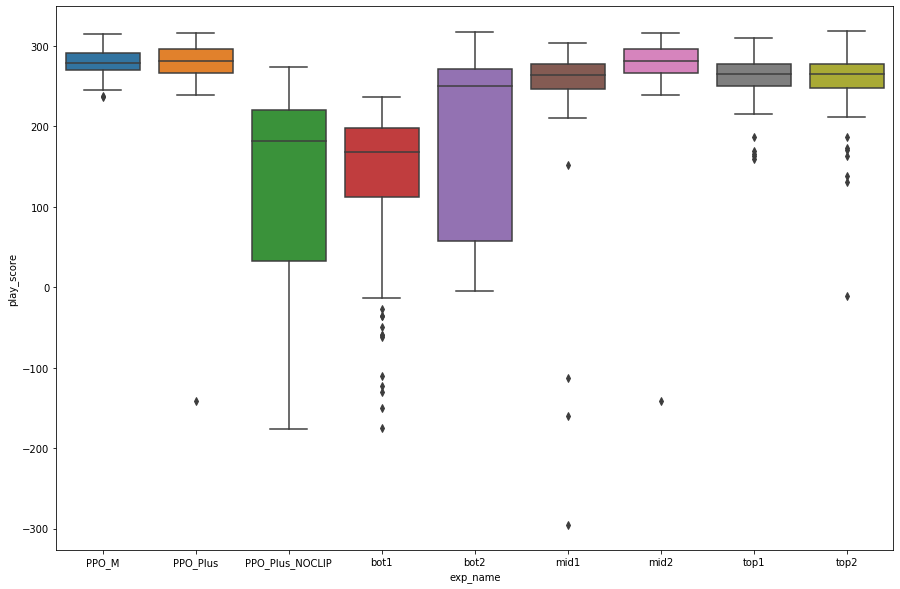

In [16]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
sns.boxplot(data=play_df, x='exp_name', y='play_score', ax=ax)
plt.show()

## 2-2. Play Score Mean & Std

In [17]:
play_df.groupby('exp_name').agg({'play_score': {'mean', 'std'}}).sort_values(by=('play_score', 'mean'), ascending=False)

play_score            
                        std        mean
exp_name                               
PPO_M             17.178128  278.675547
mid2              46.690943  276.279392
PPO_Plus          46.690943  276.279392
top1              28.760153  262.316429
top2              42.622890  257.274191
mid1              81.864192  249.457016
bot2             107.818326  184.669582
bot1              99.946706  130.814081
PPO_Plus_NOCLIP  121.860538  125.185360